In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.metrics import Recall

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df= pd.read_csv("./dataset/myDataset/myDataset.csv", encoding='utf-16')
df.head()

,sentence,type
0,a,1
1,a',1
2,a' --,1
3,a' or 1 = 1; --,1
4,@,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  18880 non-null  object
 1   type      18900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 295.4+ KB


In [7]:
df.dropna(inplace=True) # removing the values that are not numbers

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of malicious and benign queries')

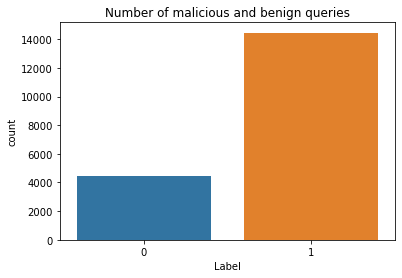

In [8]:
sns.countplot(df.type)
plt.xlabel('Label')
plt.title('Number of malicious and benign queries')

In [9]:
X=df['sentence']
y=df['type']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Paraprocesimi i te dhenave

In [11]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [12]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=[Recall()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [14]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
95/95 [==============================] - 18s 154ms/step - loss: 0.1715 - recall: 0.9804 - val_loss: 0.0391 - val_recall: 0.9983


In [15]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [16]:
recall = model.evaluate(X_test_sequences_matrix,y_test)

118/118 [==============================] - 3s 20ms/step - loss: 0.0317 - recall: 0.9969


In [17]:
print('Test set\n Loss: {:0.3f}\n Recall: {:0.3f}'.format(recall[0],recall[1]))

Test set
 Loss: 0.032
 Recall: 0.997


In [18]:
y_pred=model.predict(X_test_sequences_matrix)

In [19]:
print(y_pred)

[[0.9972731 ]
 [0.99999964]
 [0.00249526]
 ...
 [0.9970838 ]
 [0.9999636 ]
 [0.99730873]]


In [20]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [21]:
print(y_pred)

[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy= accuracy_score(y_test, y_pred)
precision= precision_score(y_test, y_pred, zero_division=1)
recall= recall_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

 Accuracy : 0.9907309322033898 
 Precision : 0.9911111111111112 
 Recall : 0.9969050894085282


Saving the model

In [24]:
from keras.models import load_model
from pathlib import Path

model.save_weights("lstm_weights.h5")
print('done')

model.save('lstm_model.h5')

done


In [25]:
loaded_model = tf.keras.models.load_model('lstm_model.h5')
loaded_model.load_weights('lstm_weights.h5') 

In [27]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

regressor = GradientBoostingClassifier()
regressor.fit(sequences_matrix, y_train)

GradientBoostingClassifier()

In [29]:
y_pred_log_reg=regressor.predict(X_test_sequences_matrix)

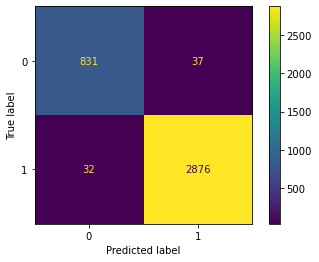

 Accuracy : 0.9817266949152542 
 Precision : 0.9872983178853416 
 Recall : 0.9889958734525447


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred_log_reg)
plot_confusion_matrix(regressor, X_test_sequences_matrix, y_test)  
plt.show()
accuracy=accuracy_score(y_test, y_pred_log_reg)
precision=precision_score(y_test, y_pred_log_reg, zero_division=1)
recall=recall_score(y_test, y_pred_log_reg, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

In [32]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
log_reg = LogisticRegression()
log_reg.fit(sequences_matrix, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
y_pred_log_reg=log_reg.predict(X_test_sequences_matrix)

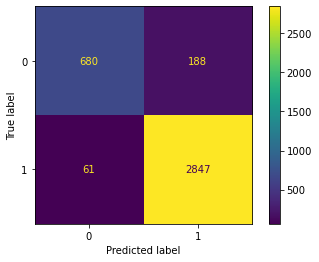

 Accuracy : 0.9340572033898306 
 Precision : 0.9380560131795717 
 Recall : 0.9790233837689133


In [34]:
confusion_matrix(y_test, y_pred_log_reg)
plot_confusion_matrix(log_reg, X_test_sequences_matrix, y_test)  
plt.show()
accuracy=accuracy_score(y_test, y_pred_log_reg)
precision=precision_score(y_test, y_pred_log_reg, zero_division=1)
recall=recall_score(y_test, y_pred_log_reg, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))

In [37]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

bag_clf = RandomForestClassifier(n_estimators=10, max_features= 4, bootstrap= False)
bag_clf.fit(sequences_matrix, y_train)
y_pred_random = bag_clf.predict(X_test_sequences_matrix)

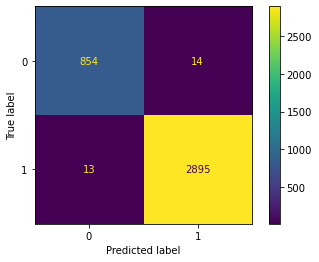

 Accuracy : 0.9928495762711864 
 Precision : 0.9951873496046751 
 Recall : 0.9955295735900963


In [38]:
confusion_matrix(y_test, y_pred_random)
plot_confusion_matrix(bag_clf, X_test_sequences_matrix, y_test)  
plt.show()
accuracy=accuracy_score(y_test, y_pred_random)
precision=precision_score(y_test, y_pred_random, zero_division=1)
recall=recall_score(y_test, y_pred_random, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2}".format(accuracy, precision, recall))